# 흐린 사진을 선명하게

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

### 1) 고해상도 이미지 열화 후 Super Resolution 하기

In [1]:
# 모듈 import
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as show_gif

In [2]:
# 이미지 불러오기
image_dir = './images/cat_resize.jpg'

hr_image = np.array(Image.open(image_dir).convert('RGB'))
hr_shape = hr_image.shape[:2]

print(hr_image.shape) # 이미지의 크기를 출력합니다.

(600, 960, 3)


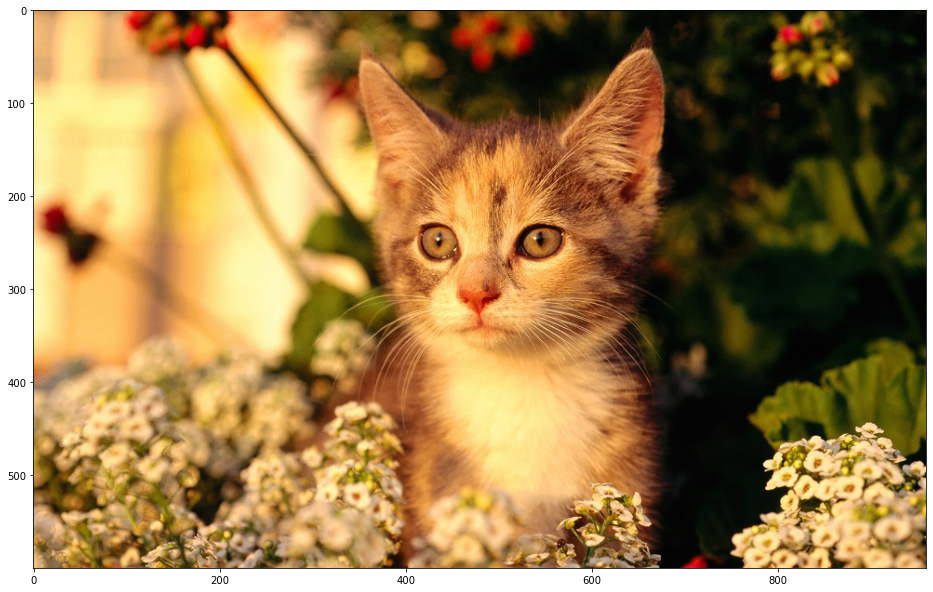

In [3]:
plt.figure(figsize=(16,12))
plt.imshow(hr_image)

(150, 240, 3)


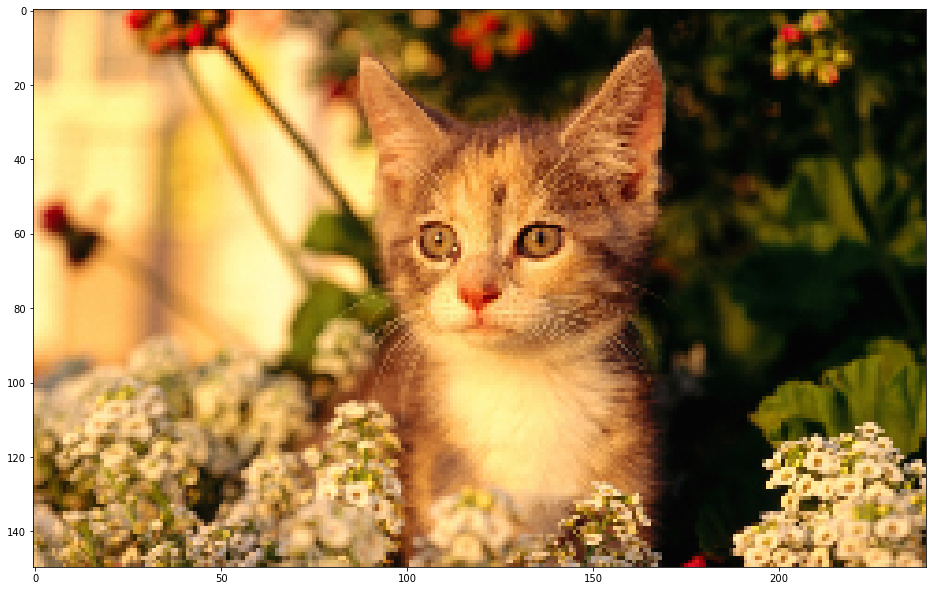

In [4]:
# 화질 열화시키기
import cv2
lr_image = cv2.resize(hr_image, dsize=(hr_shape[1] // 4, hr_shape[0] // 4)) # (가로 픽셀 수, 세로 픽셀 수)

print(lr_image.shape)

plt.figure(figsize=(16,12))
plt.imshow(lr_image)

In [5]:
# bicubic을 이용하여 scale up
bicubic_hr = cv2.resize(
    lr_image, 
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

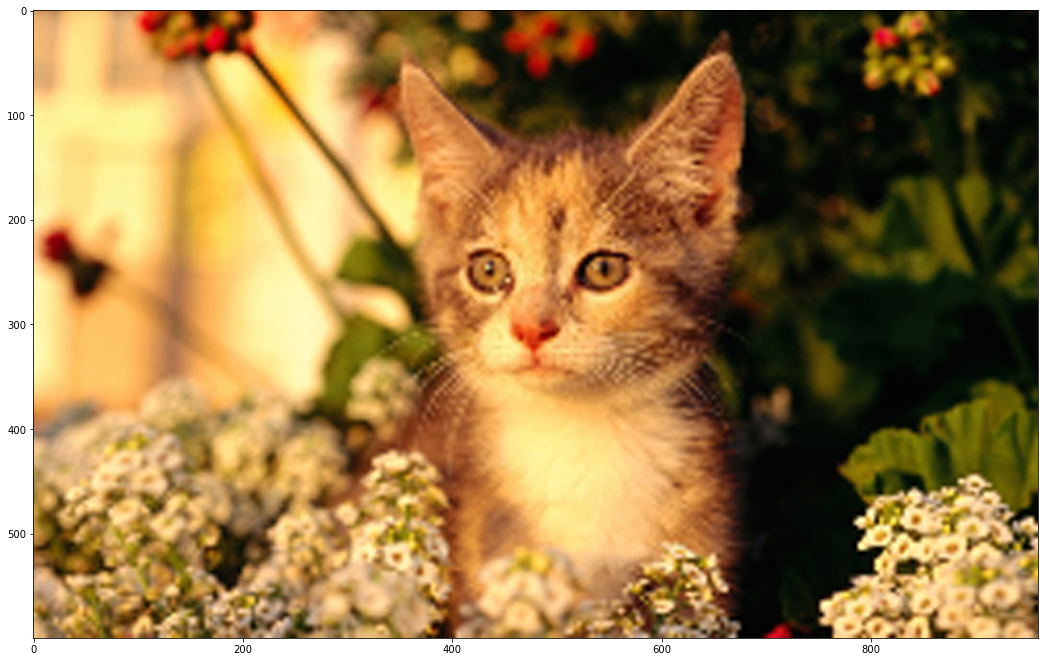

In [6]:
plt.figure(figsize=(18, 12))
plt.imshow(bicubic_hr)

In [7]:
# Crop 함수 정의
def crop(image, left_top, x=100, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

In [8]:
# SRGAN Model load
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [9]:
# SRGAN 이미지 생성 함수
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [10]:
# SRGAN 이미지 생성
srgan_hr = apply_srgan(lr_image)

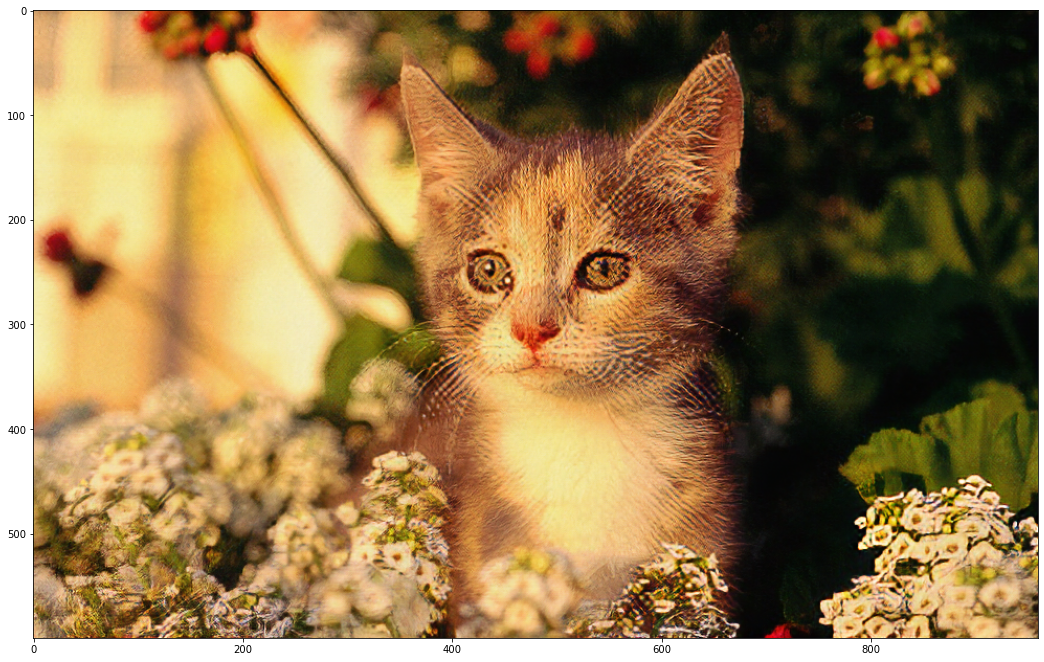

In [11]:
plt.figure(figsize=(18,12))
plt.imshow(srgan_hr)

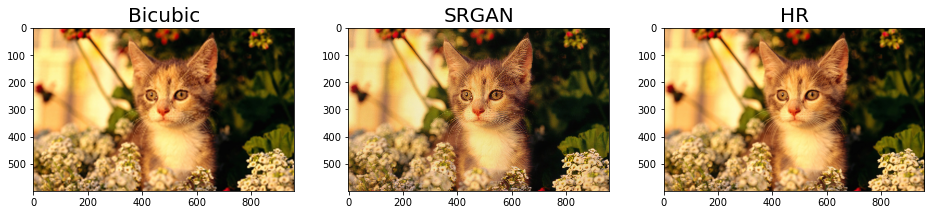

In [12]:
images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

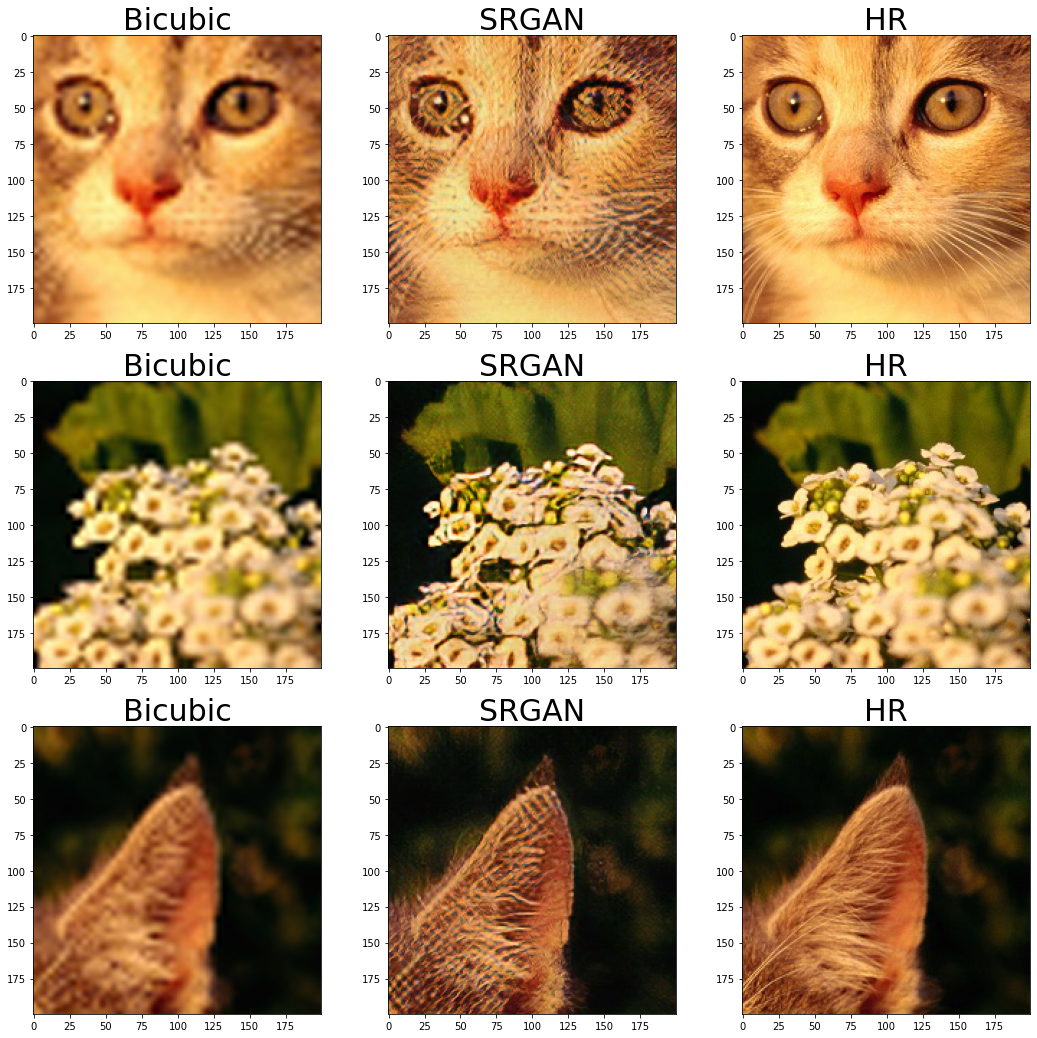

In [13]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(200,400), (400,760), (0,550)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

- SRGAN을 이용하여 Scale Up 시킨 이미지가 잘 생성된 부분도 있는 반면에 RGB 채널이 나뉘어져 보이는 것 같은 부분도 있었다.
- 고양이의 털 처럼 세부적인 특징은 정보량이 부족해서 고해상도 이미지를 자연스럽게 만들기 어려운 것 같다. 반면에 2번째 이미지 처럼 주변과 큰 차이가 없는 부분들은 Bicubic 보다는 선명한 이미지를 보여주었다.

### 2) 저해상도 이미지로 Super Resolution 하기

In [14]:
image_dir = './images/cat_lr.jpg'

lr_image = np.array(Image.open(image_dir).convert('RGB'))
lr_shape = lr_image.shape[:2]

print(lr_image.shape) # 이미지의 크기를 출력합니다.

(150, 240, 3)


In [15]:
lr_shape

(150, 240)

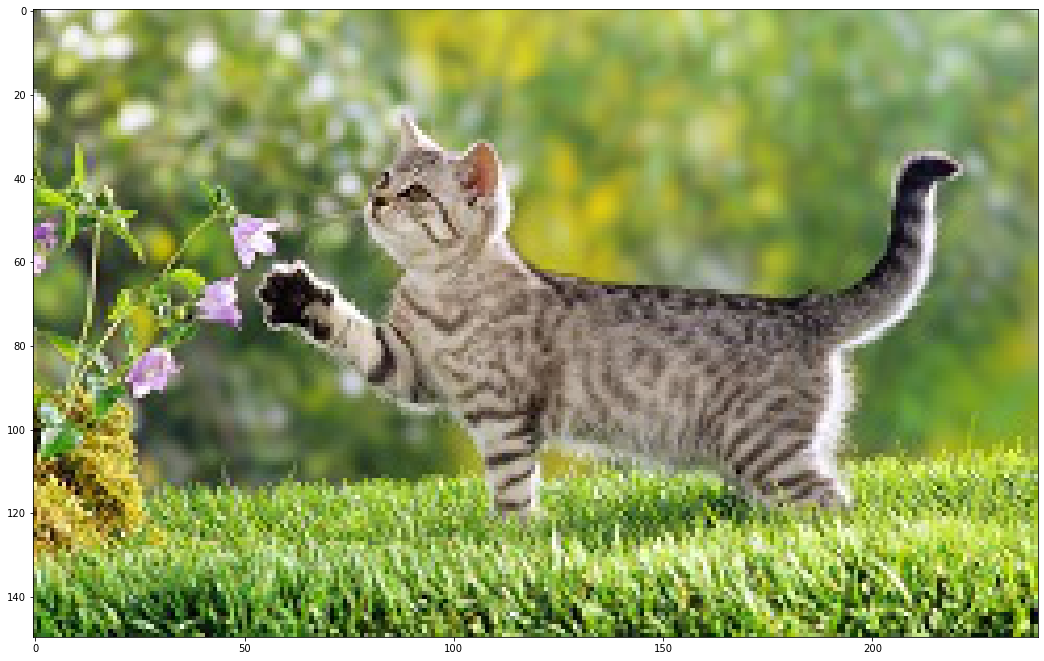

In [16]:
plt.figure(figsize=(18,12))
plt.imshow(lr_image)

In [17]:
# bicubic을 이용하여 scale up
bicubic_hr = cv2.resize(
    lr_image, 
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

In [18]:
srgan_hr = apply_srgan(lr_image)

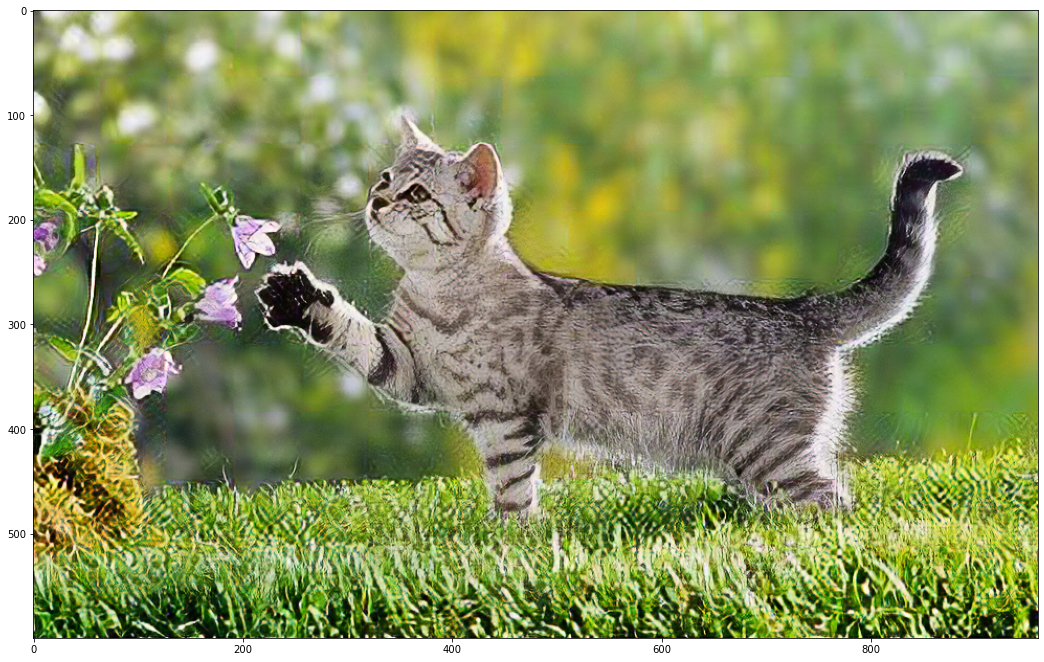

In [19]:
plt.figure(figsize=(18,12))
plt.imshow(srgan_hr)

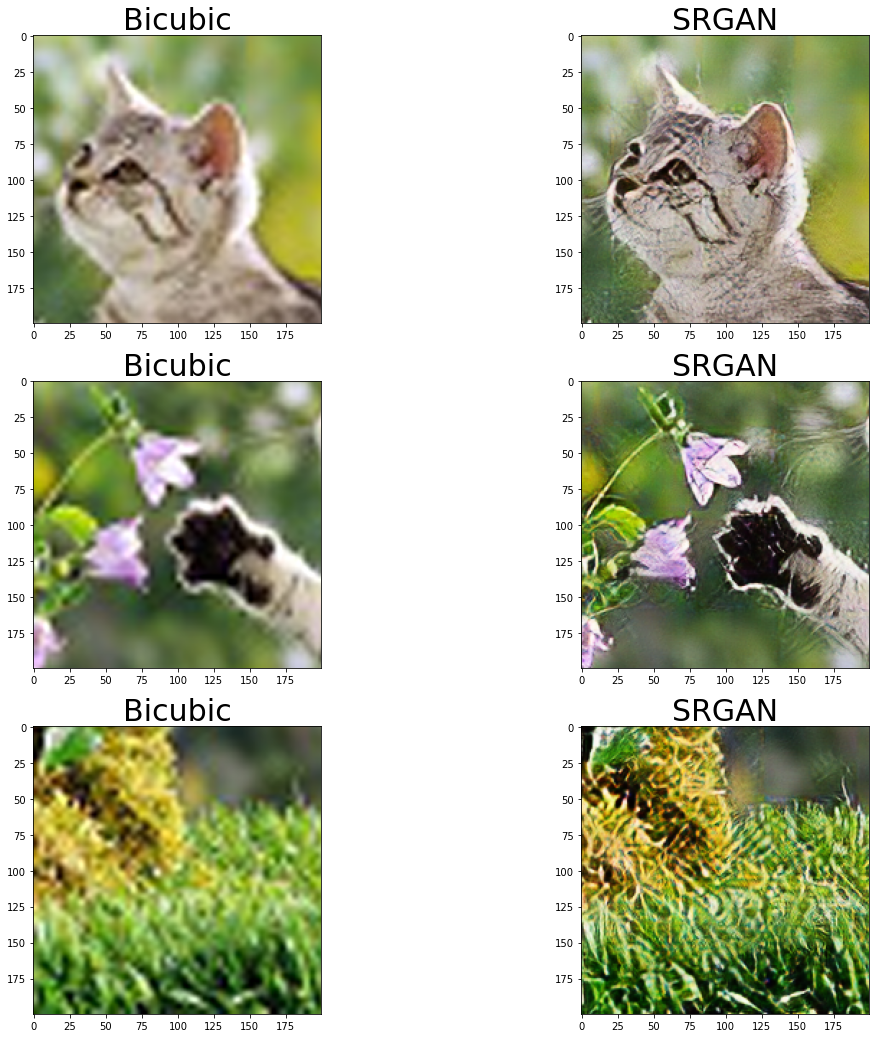

In [20]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(80,300), (160, 120), (400,0)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(18,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

- 고해상도 이미지를 열화시켜서 SRGAN으로 Scale Up한 이미지나 저해상도 이미지를 SRGAN으로 Scale Up한 이미지나 큰 차이가 없는 것 같다.
- 마찬가지로 전체적인 특징은 잘 표현하였지만 픽셀 수가 적을 수록 그만큼 유추해야 하는 정보가 많기 때문에 세부적인 특징은 제대로 묘사하기 어려운 것 같다.

## 프로젝트 2 : SRGAN을 이용하여 고해상도 GIF 생성하기

### 1) GIF 파일 불러오기

In [21]:
# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("./images/fire_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 14
frame 크기 : (282, 300, 3)


### 2) Frame 별 Super Resolution 진행하기

In [22]:
# bicubic을 이용하여 scale up
def apply_bicubic(image):
    bicubic_hr = cv2.resize(
        image, 
        dsize=(image.shape[1] * 4, image.shape[0] * 4), # 고해상도 이미지 크기로 설정
        interpolation=cv2.INTER_CUBIC # bicubic 설정
    )
    return bicubic_hr

In [23]:
frame_bicubic = []
frame_srgan = []

for frame in frames:
    frame_bicubic.append(apply_bicubic(frame))
    frame_srgan.append(apply_srgan(frame))

print(f'bicubic shape : {frame_bicubic[0].shape}')
print(f'SRGAN   shape : {frame_srgan[0].shape}')

bicubic shape : (1128, 1200, 3)
SRGAN   shape : (1128, 1200, 3)


### 3) Frame을 합쳐 GIF 만들기

In [24]:
import imageio

imageio.mimsave("./images/frame_bicubic.gif", frame_bicubic)
imageio.mimsave("./images/frame_srgan.gif", frame_srgan)

### 4) Jupyter notebook에 GIF 표시하기

### Original

![original](./images/fire_lr.gif)

### bicubic

![bicubic](./images/frame_bicubic.gif)

### SRGAN

![SRGAN](./images/frame_srgan.gif)

- 확실히 원본 gif보다는 bicubic이나 SRGAN으로 Scale Up시킨 gif파일이 더 선명하고 픽셀이 보이는 현상이 덜하다.

## 회고록
- 노드를 진행하기 전에 이미 SRCNN으로 만들어진 waifu2x 라는 앱을 알고 있었기 때문에 노드를 진행하는데 있어서 어려움이 없었다.
- 실제 작동 원리에 대해서는 잘 알지 못했었는데 이번 노드를 통해서 확실하게 이해한 것 같다.
- 이미지 분야에서는 CNN이 정말 만능처럼 보인다. 어느 분야에서든지 사용만 하면 결과물을 바로 볼 수 있어서 그런지 더 체감이 큰 것 같다.